In [1]:
import sys
sys.path.insert(0, '../../../network')

In [2]:
import logging
import argparse
import numpy as np
from network import Population, RateNetwork
from learning import ReachingTask
from transfer_functions import ErrorFunction
from connectivity import SparseConnectivity, LinearSynapse, ThresholdPlasticityRule, set_connectivity 
from sequences import GaussianSequence
import matplotlib.pyplot as plt
import seaborn as sns
logging.basicConfig(level=logging.INFO)

In [3]:
phi = ErrorFunction(mu=0.22, sigma=0.1).phi
plasticity = ThresholdPlasticityRule(x_f=0.5, q_f=0.8)

# populations
ctx = Population(N=1000, tau=1e-2, phi=phi, name='ctx')
d1 = Population(N=1000, tau=1e-2, phi=phi, name='d1')
d2 = Population(N=1000, tau=1e-2, phi=phi, name='d2')
pops = np.array([ctx, d1, d2])

# patterns 
S, P = 1, 3
sequences_ctx = [GaussianSequence(P,ctx.size, seed=114) for i in range(S)]
patterns_ctx = np.stack([s.inputs for s in sequences_ctx])
sequences_d1 = [GaussianSequence(P,d1.size, seed=29) for i in range(S)]
patterns_d1 = np.stack([s.inputs for s in sequences_d1])
sequences_d2 = [GaussianSequence(P,d2.size, seed=29) for i in range(S)]
patterns_d2 = np.stack([s.inputs for s in sequences_d2])
patterns = [patterns_ctx, patterns_d1, patterns_d2]

# connectivity probabilities
cp = np.array([[0.05, 0.05, 0.05], 
               [0.05, 0.05, 0.3],
               [0.05, 0.3, 0.05]])
cw = np.array([[0, 1, -1],
               [0, 0, -1],
               [0, -1, 0]])

Ai1 = np.vstack([[[5,0,0],
                  [0,5,0],
                  [0,0,5]],
                 [[0,0,.1],
                  [.1,0,0],
                  [0,.1,0]],
                 [[0,0,.1],
                  [.1,0,0],
                  [0,.1,0]]])

Ai2 = np.vstack([[[0,0,0],
                  [0,0,0],
                  [0,0,0]],
                 [[5,0,0],
                  [0,5,0],
                  [0,0,5]],
                 [[0,0,0],
                  [0,0,0],
                  [0,0,0]]])

Ai3 = np.vstack([[[1,0,0],
                  [0,1,0],
                  [0,0,1]],
                 [[0,0,0],
                  [0,0,0],
                  [0,0,0]],
                 [[5,0,0],
                  [0,5,0],
                  [0,0,5]]])

A = np.hstack([Ai1, Ai2, Ai3])


plasticity_rule = np.array([[0, 2, 0],
                            [1, 0, 2],
                            [1, 2, 0]])

J = set_connectivity(pops, cp, cw, A, plasticity_rule, patterns, plasticity)

network = RateNetwork(pops, J, formulation=5)

INFO:connectivity:Building connections from ctx to ctx


[[5. 0. 0.]
 [0. 5. 0.]
 [0. 0. 5.]]


INFO:connectivity:Building connections from ctx to d1


[[0.  0.  0.1]
 [0.1 0.  0. ]
 [0.  0.1 0. ]]


INFO:connectivity:Building connections from ctx to d2


[[0.  0.  0.1]
 [0.1 0.  0. ]
 [0.  0.1 0. ]]


INFO:connectivity:Building connections from d1 to ctx


[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


INFO:connectivity:Building connections from d1 to d1


[[5. 0. 0.]
 [0. 5. 0.]
 [0. 0. 5.]]


INFO:connectivity:Building connections from d1 to d2
INFO:connectivity:Building connections from d2 to ctx


[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


INFO:connectivity:Building connections from d2 to d1
INFO:connectivity:Building connections from d2 to d2


[[5. 0. 0.]
 [0. 5. 0.]
 [0. 0. 5.]]


In [4]:
init_input_ctx = phi(patterns_ctx[0][0])
# init_input_bg = phi(patterns_bg[0][0])
# init_input_ctx = np.random.normal(net_ctx.size)
# init_input_d1 = np.random.normal(d1.size)
# init_input_d2 = np.random.normal(d2.size)
init_input_d1 = np.zeros(d1.size)
init_input_d2 = np.zeros(d2.size)
init_y1 = np.ones(d1.size) * .7
init_y2 = np.zeros(d2.size)
T=10
mouse = ReachingTask()

network.simulate_euler2(mouse, T, init_input_ctx, init_input_d1, init_input_d2, init_y1, init_y2,
                        patterns_ctx[0], patterns_d1[0], patterns_d2[0], detection_thres=.23,
                        noise1=.13, noise2=0.13, noise3=0.13)

INFO:network:Integrating network dynamics
100%|██████████| 9999/9999 [00:29<00:00, 342.48it/s]


In [5]:
# overlaps = sequences_ctx[0].overlaps(net_ctx, ctx, phi=phi)
overlaps_ctx = sequences_ctx[0].overlaps(network.pops[0])
overlaps_d1 = sequences_d1[0].overlaps(network.pops[1])
overlaps_d2 = sequences_d2[0].overlaps(network.pops[2])

INFO:sequences:Computing overlaps
100%|██████████| 3/3 [00:00<00:00, 93.64it/s]
INFO:sequences:Computing overlaps
100%|██████████| 3/3 [00:00<00:00, 257.98it/s]
INFO:sequences:Computing overlaps
100%|██████████| 3/3 [00:00<00:00, 239.88it/s]


In [6]:
sns.set_style('white') 
colors = sns.color_palette('deep')


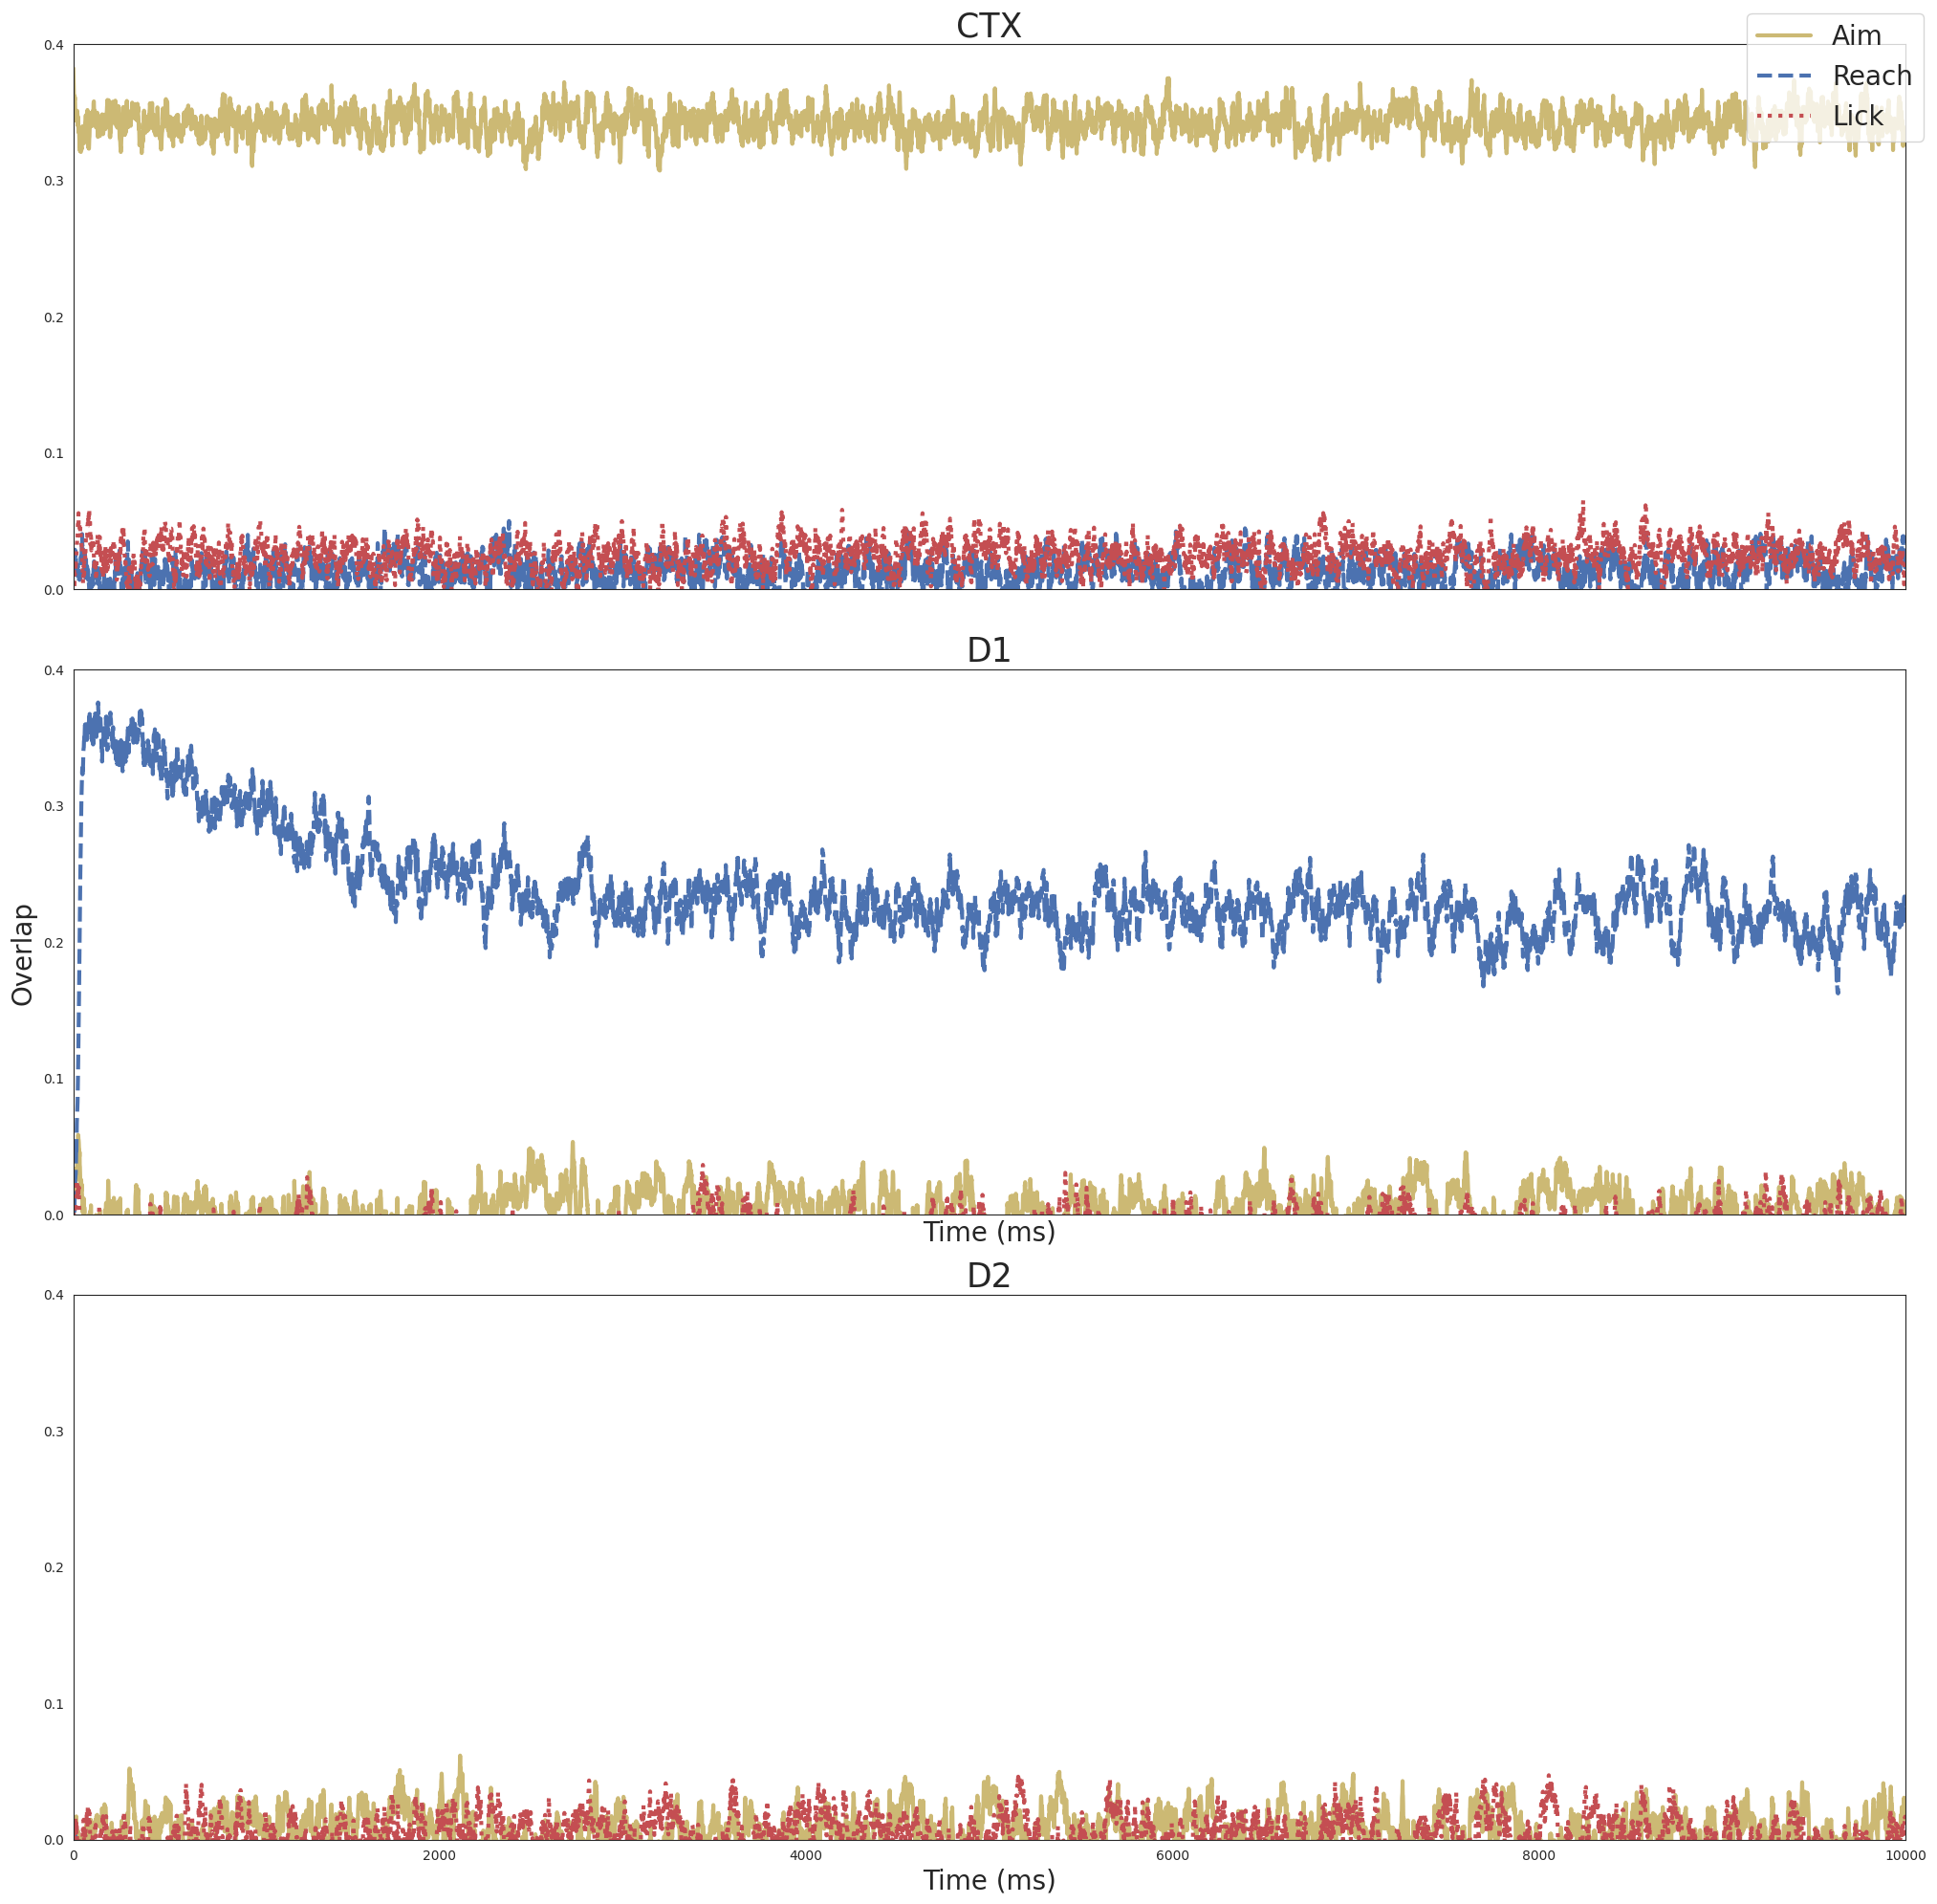

In [7]:
fig, axes = plt.subplots(3,1, sharex=True, sharey=True, tight_layout=True, figsize=(20,20))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=3, color=colors[8])
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=25)
axes[1].plot(overlaps_d1[0], linestyle='solid', linewidth=3, color=colors[8])
axes[1].plot(overlaps_d1[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[1].plot(overlaps_d1[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("D1", fontsize=25)
axes[1].set_xlabel('Time (ms)', fontsize=20)
axes[2].plot(overlaps_d2[0], linestyle='solid', linewidth=3, color=colors[8])
axes[2].plot(overlaps_d2[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[2].plot(overlaps_d2[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[2].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[2].set_title("D2", fontsize=25)
axes[2].set_xlabel('Time (ms)', fontsize=20)
fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(0, 10000))
plt.setp(axes, ylim=(0, 0.4))
plt.figlegend(labels=['Aim', 'Reach', 'Lick'], fontsize=20)
plt.savefig('./d1d2.png', bbox_inches = "tight", format='png')

plt.show()


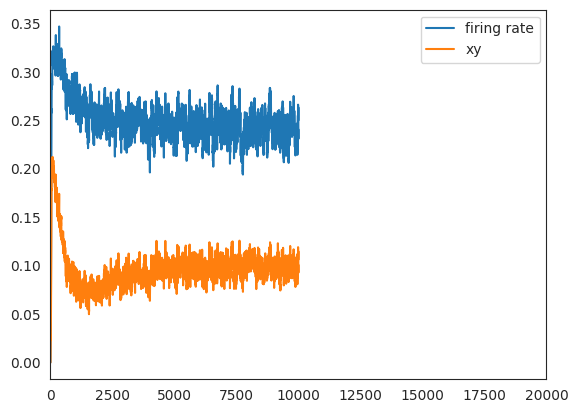

In [8]:
plt.plot(np.average(network.pops[1].state, axis=0), label='firing rate')
plt.plot(np.average(network.pops[1].depression * network.pops[1].state, axis=0), label='xy')
plt.xlim(0, 20000)
plt.legend()
plt.savefig('./d1avg.png', bbox_inches = "tight", format='png')




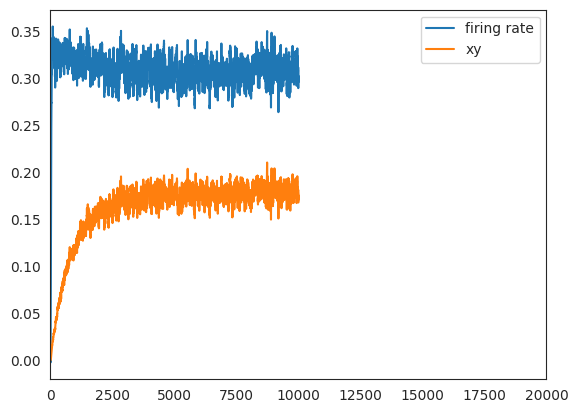

In [9]:
plt.plot(np.average(network.pops[2].state, axis=0), label='firing rate')
plt.plot(np.average(network.pops[2].depression * network.pops[2].state, axis=0), label='xy')
plt.xlim(0, 20000)
plt.legend()
plt.savefig('./d2avg.png', bbox_inches = "tight", format='png')